In [1]:
import os
import re
import math
from collections import defaultdict
import pandas as pd
import numpy as np
import json
import folium
from folium import plugins
from folium.plugins import HeatMap
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min

from IPython.core.display import display, HTML

# Turn slice copy warnings off
pd.options.mode.chained_assignment = None

import findspark
findspark.init()
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.types import ArrayType, StringType, DoubleType, IntegerType, FloatType

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
data_folder = './data/'

### Crime Data Exploration

This dataset examins NYPD complaint data from 2006 through 2017, giving us information about crime trends throughout that time period. The data is taken from New York City's opendata website, and the exact source is given in our project's readme. Let's start off by writing the data to a parquet file, which we will load to cut down on run times.

#### Data Cleaning and Preprocessing

In [3]:
df = spark.read.csv(data_folder + "NYPD_Complaint_Data_Historic.csv")
df.write.mode("overwrite").parquet(data_folder + "nypd.parquet")
df = spark.read.parquet(data_folder + "nypd.parquet")

In [4]:
df.show(5)

+---------+----------+--------+----------+--------+---+----------+---+--------------------+---+--------------------+---------+-----------+---------+------+--------------------+----------------+----+----+----+----+-------+------+----+-----+----+----+------------+-------------+--------------------+--------------------+----+-----+-------+----+
|      _c0|       _c1|     _c2|       _c3|     _c4|_c5|       _c6|_c7|                 _c8|_c9|                _c10|     _c11|       _c12|     _c13|  _c14|                _c15|            _c16|_c17|_c18|_c19|_c20|   _c21|  _c22|_c23| _c24|_c25|_c26|        _c27|         _c28|                _c29|                _c30|_c31| _c32|   _c33|_c34|
+---------+----------+--------+----------+--------+---+----------+---+--------------------+---+--------------------+---------+-----------+---------+------+--------------------+----------------+----+----+----+----+-------+------+----+-----+----+----+------------+-------------+--------------------+-----------------

Let's rename the columns to column names from the dataset description to make future manipulations easier.

In [5]:
cols = ["Comp_Num", "Comp_FR_Date", "Comp_FR_Time", "Comp_TO_Date", "Comp_TO_TIME", "Addr_PCT_CD",\
       "RPT_DT", "KY_DC", "OFNS_DESC", "PD_CD", "PD_DESC", "Crime_Completed", "LAW_CAT_CD", "BORO_NM",\
        "LOC_OF_OCCUR", "PREM_TYPE", "JURIS_DESC", "JURIS_CODE", "PARKS_NM", "HADEVELOPT", "HOUSING_PSA",\
       "X_COORD_CD", "Y_COORD_CD", "SUSP_AGE_GROUP", "SUSP_RACE", "SUSP_SEX", "TRANS_DIST", "Latitude",\
       "Longitude", "Lat_Lon", "PATROL_BORO", "STATION_NAME", "VIC_AGE_GROUP", "VIC_RACE", "VIC_SEX"]
df = df.toDF(*cols)
df.show(5)

+---------+------------+------------+------------+------------+-----------+----------+-----+--------------------+-----+--------------------+---------------+-----------+---------+------------+--------------------+----------------+----------+--------+----------+-----------+----------+----------+--------------+---------+--------+----------+------------+-------------+--------------------+--------------------+------------+-------------+--------+-------+
| Comp_Num|Comp_FR_Date|Comp_FR_Time|Comp_TO_Date|Comp_TO_TIME|Addr_PCT_CD|    RPT_DT|KY_DC|           OFNS_DESC|PD_CD|             PD_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|LOC_OF_OCCUR|           PREM_TYPE|      JURIS_DESC|JURIS_CODE|PARKS_NM|HADEVELOPT|HOUSING_PSA|X_COORD_CD|Y_COORD_CD|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|TRANS_DIST|    Latitude|    Longitude|             Lat_Lon|         PATROL_BORO|STATION_NAME|VIC_AGE_GROUP|VIC_RACE|VIC_SEX|
+---------+------------+------------+------------+------------+-----------+----------+-----+--

We can start off by immediately dropping the features which do not seem important. We will leave information on the time of the crime, information about the crime itself, and demographic information about the victim and the perpretrator.

In [6]:
drop_list = ["Comp_FR_", "HADEVELOPT", "HOUSING_PSA", "JURIS_CODE", "JURIS_DESC", "LOC_OF_OCCUR",\
            "PARKS_NM", "PREM_TYPE", "RPT_DT", "STATION_NAME", "PATROL_BORO", "TRANS_DIST",\
            "X_COORD_CD", "Y_COORD_CD", "Addr_PCT_CD", "Lat_Lon", "Comp_TO_Date", "Comp_TO_TIME",\
             "KY_DC", "PD_CD", "PD_DESC"]
df = df.select([column for column in df.columns if column not in drop_list])

In [7]:
df.show(5)

+---------+------------+------------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------+-------+
| Comp_Num|Comp_FR_Date|Comp_FR_Time|           OFNS_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|    Latitude|    Longitude|VIC_AGE_GROUP|VIC_RACE|VIC_SEX|
+---------+------------+------------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------+-------+
|595775572|  10/30/2008|    12:00:00|       GRAND LARCENY|      COMPLETED|     FELONY| BROOKLYN|          null|    BLACK|       F|40.665617714|-73.899076401|          <18|   BLACK|      F|
|375177250|  10/30/2008|    12:00:00|       PETIT LARCENY|      COMPLETED|MISDEMEANOR|MANHATTAN|          null|     null|    null|40.751600254|-73.992043061|         null| UNKNOWN|      D|
|513357035|  10/30/2008|    12:00:00|CRIMINAL MISCHIEF.

Let's now clean the data. Let's remove crimes with invalid date, time, and location data; as our intended visualization will involve maps and this invalid data makes up an extremely small proportion of the dataset, it makes more sense to just remove it.

In [8]:
df = df.where(df["Comp_FR_Date"].isNotNull())
df = df.where(df["Comp_FR_Time"].isNotNull())
df = df.where(df["Latitude"].isNotNull())

Let's now create a column that combines the date and time information into a single datetime column.

In [9]:
df.registerTempTable("df")
date = spark.sql("SELECT Comp_Num, CONCAT(Comp_FR_Date, ' ',  Comp_FR_Time) as Date FROM df")
df = df.join(date, ["Comp_Num"])
df = df.withColumn("Date", to_timestamp(df.Date, 'MM/dd/yyyy HH:mm:ss'))
df.show(5)

+---------+------------+------------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------------+-------+-------------------+
| Comp_Num|Comp_FR_Date|Comp_FR_Time|           OFNS_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|    Latitude|    Longitude|VIC_AGE_GROUP|      VIC_RACE|VIC_SEX|               Date|
+---------+------------+------------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------------+-------+-------------------+
|100027190|  08/01/2008|    17:23:00|       PETIT LARCENY|      COMPLETED|MISDEMEANOR|MANHATTAN|          null|     null|    null|40.747327396|-73.976961498|         null|       UNKNOWN|      D|2008-08-01 17:23:00|
|100030303|  06/23/2016|    21:00:00|       GRAND LARCENY|      COMPLETED|     FELONY|    BRONX|          null|     null|    null|40.8638386

Let's now drop the old date and time columns, and write this to a parquet. This contains all of the information that we will need at the moment. In addition to this, our dataset only proports to be from 2006-2017; thus, let's also remove any rows with dates that are less than 2006.

In [10]:
df = df.drop("Comp_FR_Date").drop("Comp_FR_Time")
df = df.filter(df.Date >= lit("2006-01-01"))
df.write.mode("overwrite").parquet(data_folder + "nypd_filtered.parquet")

Loading the data again, we can now proceed with analysis of the data.

#### Crime Dataset Data Analysis

In [11]:
df = spark.read.parquet(data_folder + "nypd_filtered.parquet")

In [12]:
df.show(5)

+---------+--------------------+---------------+-----------+---------+--------------+--------------+--------+------------+-------------+-------------+--------------+-------+-------------------+
| Comp_Num|           OFNS_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|SUSP_AGE_GROUP|     SUSP_RACE|SUSP_SEX|    Latitude|    Longitude|VIC_AGE_GROUP|      VIC_RACE|VIC_SEX|               Date|
+---------+--------------------+---------------+-----------+---------+--------------+--------------+--------+------------+-------------+-------------+--------------+-------+-------------------+
|100003098|OFFENSES AGAINST ...|      COMPLETED|MISDEMEANOR|MANHATTAN|         25-44|BLACK HISPANIC|       M|40.811130194|-73.936714506|        25-44|WHITE HISPANIC|      F|2014-10-02 13:40:00|
|100023642|CRIMINAL MISCHIEF...|      COMPLETED|     FELONY|    BRONX|         18-24|         BLACK|       M|40.791151867|-73.884371919|         null|       UNKNOWN|      E|2013-11-09 19:15:00|
|100038353|      FELONY ASSAUL

Let's first examine the offense descriptions, by finding the top ten most commonly occurring crimes.

In [13]:
df.registerTempTable("df")
query = """select OFNS_DESC, min(LAW_CAT_CD) as category, count(OFNS_DESC) as count 
    from df
    group by ofns_desc
    order by count desc
    limit 10"""
spark.sql(query).show()

+--------------------+-----------+------+
|           OFNS_DESC|   category| count|
+--------------------+-----------+------+
|       PETIT LARCENY|MISDEMEANOR|981460|
|       HARRASSMENT 2|  VIOLATION|732754|
|ASSAULT 3 & RELAT...|MISDEMEANOR|622173|
|CRIMINAL MISCHIEF...|     FELONY|600613|
|       GRAND LARCENY|     FELONY|510969|
|     DANGEROUS DRUGS|     FELONY|389070|
|OFF. AGNST PUB OR...|MISDEMEANOR|324903|
|             ROBBERY|     FELONY|226287|
|      FELONY ASSAULT|     FELONY|223877|
|            BURGLARY|     FELONY|215315|
+--------------------+-----------+------+



As can be seen, the most common crime committed is petit larceny, which New York defines to be the theft of objects with monetary value of no more than 1000 dollars. Grand larceny is also on the list, which is for items of value greater than 1000 dollars. Most of the items on the list are felonies (the most severe crimes), while only a few are misdemeanors (the least severe crime category). There is only one of the middle category on the list. Let's now examine the counts of the three categories in total.

In [14]:
df.groupBy("LAW_CAT_CD").count().sort(col("count").desc()).show()

+-----------+-------+
| LAW_CAT_CD|  count|
+-----------+-------+
|MISDEMEANOR|3414803|
|     FELONY|1839034|
|  VIOLATION| 745632|
+-----------+-------+



The majority of crimes committed are misdemeanors. Only 745,000 violations were committed over this timeframe, and 733,000 of them were in the "harassment 2" category, which corresponds with harrassment in the 2nd degree. Otherwise, we can see that nearly 1/3 of the felonies are criminal mischief charges, with grand larceny also taking up a similar proportion. 

Let's now look at the count per borough.

In [15]:
df.groupBy("BORO_NM").count().sort(col("count").desc()).show()

+-------------+-------+
|      BORO_NM|  count|
+-------------+-------+
|     BROOKLYN|1786643|
|    MANHATTAN|1434961|
|        BRONX|1300000|
|       QUEENS|1183943|
|STATEN ISLAND| 284300|
|         null|   9622|
+-------------+-------+



Brooklyn has the most crimes committed by a decent margin, followed by Manhattan, the Bronx, and Queens. Staten Island is far behind, which makes sense due to its smaller size and population. Let's now examine how much crime happens in different hours of the day.

In [16]:
hours = df.select("Date", "LAW_CAT_CD").withColumn("Hour", hour(df.Date)).drop("Date")
hours.groupBy("Hour").count().sort(col("Hour").asc()).show()

+----+------+
|Hour| count|
+----+------+
|   0|284045|
|   1|206995|
|   2|165946|
|   3|139862|
|   4|122590|
|   5| 85913|
|   6| 87574|
|   7|124400|
|   8|201464|
|   9|221439|
|  10|230515|
|  11|236269|
|  12|329199|
|  13|282808|
|  14|319956|
|  15|361601|
|  16|344267|
|  17|345283|
|  18|354435|
|  19|342792|
+----+------+
only showing top 20 rows



We can see from this table that the amount of crimes starts off fairly high, decreases as the night goes on,  and heats a peak in the mid-afternoon. Let's plot this data, along with the trends for each individual crime type.

In [17]:
total = hours.groupBy("Hour").count().sort(col("Hour").asc())
categories = hours.groupBy("Hour", "LAW_CAT_CD").count().orderBy(col("Hour").asc(), "LAW_CAT_CD")
total = total.toPandas()
categories = categories.toPandas()

<BarContainer object of 24 artists>

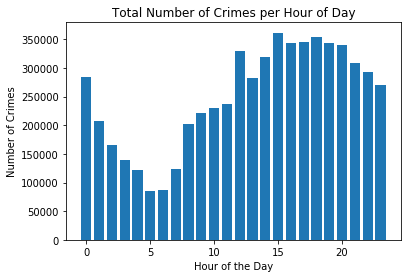

In [18]:
plt.title("Total Number of Crimes per Hour of Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Crimes")
plt.bar(total["Hour"], total["count"])

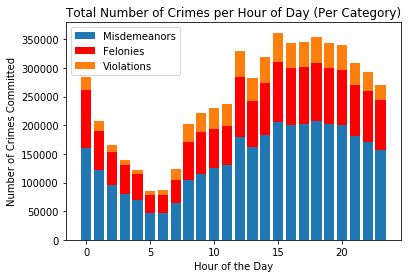

In [19]:
felonies = categories[categories.LAW_CAT_CD == "FELONY"].reset_index(drop=True)
misdemeanors = categories[categories.LAW_CAT_CD == "MISDEMEANOR"].reset_index(drop=True)
violations = categories[categories.LAW_CAT_CD == "VIOLATION"].reset_index(drop=True)

plt.title("Total Number of Crimes per Hour of Day (Per Category)")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Crimes Committed")

p1 = plt.bar(misdemeanors["Hour"], misdemeanors["count"])
p2 = plt.bar(felonies["Hour"], felonies["count"], bottom=misdemeanors["count"], color="red")
p3 = plt.bar(violations["Hour"], violations["count"], bottom=(misdemeanors["count"] + felonies["count"]), color="C1")
plt.legend((p1[0], p2[0], p3[0]), ('Misdemeanors', 'Felonies', 'Violations'))

The individual categories follow a similar trend as the total. There is a consistent ordering between the number of misdemeanors, felonies, and violations for every hour. For the last bit of our preliminary analysis, let's use maps to show the geographical trends of the data.

As there is a lot of data, let's restrict our daily maps to just a single day. Let's choose five years before today's date, November 25th 2013.

In [20]:
day_df = df.filter(df["Date"].between('2013-11-25 00:00:00','2013-11-25 23:59:00'))
day_df.show(5)

+---------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------------------+-------+-------------------+
| Comp_Num|           OFNS_DESC|Crime_Completed| LAW_CAT_CD|  BORO_NM|SUSP_AGE_GROUP|SUSP_RACE|SUSP_SEX|    Latitude|    Longitude|VIC_AGE_GROUP|            VIC_RACE|VIC_SEX|               Date|
+---------+--------------------+---------------+-----------+---------+--------------+---------+--------+------------+-------------+-------------+--------------------+-------+-------------------+
|542665858|OFFENSES AGAINST ...|      COMPLETED|MISDEMEANOR|   QUEENS|         25-44|  UNKNOWN|       M|40.706599944|-73.795606957|        18-24|             UNKNOWN|      F|2013-11-25 19:25:00|
|746012014|       PETIT LARCENY|      COMPLETED|MISDEMEANOR|    BRONX|          null|     null|    null| 40.84521634|-73.922445246|        25-44|               BLACK|      M|2013-11-25 16:48:00|
|808274644|OFF. AGNST PUB

Let's filter out all irrelevant data and convert it into a pandas dataframe, which will allow us to plot it with folium.

In [21]:
day_df = day_df.select(["Latitude", "Longitude", "LAW_CAT_CD", "OFNS_DESC"])
day_df = day_df.toPandas()
day_df["Latitude"] = pd.to_numeric(day_df["Latitude"])
day_df["Longitude"] = pd.to_numeric(day_df["Longitude"])

Let's set up our map so we see the offense description if we click on the marker. Furthermore, let's color-code it by the severity of the violation: red for felonies, orange for violations, and blue for misdemeanors (there is no yellow marker in folium). For this map, we will also show the borders of the boroughs.

In [22]:
def color(category):
    if category == "FELONY":
        return "red"
    elif category == "VIOLATION":
        return "orange"
    else: # misdemeanor
        return "blue"

In [38]:
borough_edge = json.load(open(os.path.join('data', 'nyc-boroughs.json')))
nyc_loc = [40.7128, -73.9]

day_map = folium.Map(location = nyc_loc, zoom_start = 11)

# Shuffle the data to show random sample
day_df = day_df.sample(frac=1).reset_index(drop=True)
# We reduce the size, as too many markers prevents the map from rendering.
for i in range(300):
    folium.Marker([day_df.iloc[i]['Latitude'], day_df.iloc[i]['Longitude']], \
        popup=day_df.iloc[i]['OFNS_DESC'], icon=folium.Icon(color=color(day_df.iloc[i]["LAW_CAT_CD"])))\
        .add_to(day_map)

folium.GeoJson(
    borough_edge,
    name='geojson',
    style_function = lambda x: {'fillOpacity': 0}
).add_to(day_map)
    
day_map

Let's also make a heatmap for the day's crimes.

In [39]:
heat_data = [[row['Latitude'],row['Longitude']] for index, row in day_df.iterrows()]

heat_map = folium.Map(location = nyc_loc, zoom_start = 11.5)
HeatMap(heat_data).add_to(heat_map)

heat_map

### Education Data Analysis

We now move on to exploratory analysis for the education data. To start, let's read the data from our file.

In [25]:
ed_boroughs = pd.ExcelFile(data_folder + '2017-graduation_rates_public_borough.xlsx')
ed_sheet_names = ed_boroughs.sheet_names

In [26]:
ed_sheets = {}

for name in ed_sheet_names:
    df = ed_boroughs.parse(name, skiprows=list(range(7))) 
    ed_sheets[name] = df
df_all_students = ed_sheets[ed_sheet_names[1]]
    
# Show all of the columns
print(list(df_all_students))

# Show a few rows from the data
df_all_students.head()

['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Cohort', 'Total Grads', 'Unnamed: 6', 'Total Regents', 'Unnamed: 8', 'Unnamed: 9', 'Advanced Regents', 'Unnamed: 11', 'Unnamed: 12', 'Regents without Advanced', 'Unnamed: 14', 'Unnamed: 15', 'Local', 'Unnamed: 17', 'Unnamed: 18', 'Still Enrolled', 'Unnamed: 20', 'Dropout', 'Unnamed: 22', 'SACC (IEP Diploma)', 'Unnamed: 24', 'TASC (GED)', 'Unnamed: 26']


Unnamed: 0    Unnamed: 1   Unnamed: 2     Unnamed: 3 Cohort Total Grads  \
0    Borough      Category  Cohort Year         Cohort      #           #   
1      Bronx  All Students         2013  4 year August  13730        9102   
2      Bronx  All Students         2012  4 year August  13838        8985   
3      Bronx  All Students         2011  4 year August  14278        8821   
4      Bronx  All Students         2010  4 year August  14229        8405   

    Unnamed: 6 Total Regents   Unnamed: 8  Unnamed: 9     ...       \
0  % of cohort             #  % of cohort  % of grads     ...        
1      66.2928          8105      59.0313     89.0464     ...        
2      64.9299          8149      58.8886     90.6956     ...        
3      61.7804          8073      56.5415     91.5202     ...        
4      59.0695          7695      54.0797     91.5526     ...        

   Unnamed: 17 Unnamed: 18 Still Enrolled  Unnamed: 20 Dropout  Unnamed: 22  \
0  % of cohort  % of grads              #  % of cohort       #  % of cohort   
1      7.26147     10.9536           2742      19.9709    1606       11.697   
2      6.04134      9.3044           2876      20.7833    1757      12.6969   
3      5.23883     8.47976           3243      22.7133    1866      13.0691   
4      4.98981     8.44735           3418      24.0214    2013      14.1472   

  SACC (IEP Diploma)  Unnamed: 24 TASC (GED)  Unnamed: 26  
0                  #  % of cohort          #  % of cohort  
1                118     0.859432        151      1.09978  
2                100     0.722648        110     0.794913  
3                207      1.44978        126     0.882476  
4                240       1.6867        144      1.01202  

[5 rows x 27 columns]

We can see that, due to overlap in naming conventions as well as slightly incompatible header formatting, the column names are not very clear and the first row is simply sub-headers.  
To clean the data up, we will remove the unecessary columns and rename the remaining columns to be more readable.  
We care primarily about the raw numbers of Total Grads as well as Dropouts.

In [27]:
df_grads_dropouts = df_all_students[['Unnamed: 0', 'Unnamed: 2', 'Cohort', 'Total Grads', 'Unnamed: 6', 'Dropout', 'Unnamed: 22']]
df_grads_dropouts.rename(columns={'Unnamed: 0': 'Borough', 'Unnamed: 2': 'Year','Unnamed: 6': 'Total Grads %', 'Unnamed: 22': 'Dropout %'}, inplace=True)
df_grads_dropouts.drop(0, inplace=True)
df_grads_dropouts.head()

Borough  Year Cohort Total Grads Total Grads % Dropout Dropout %
1   Bronx  2013  13730        9102       66.2928    1606    11.697
2   Bronx  2012  13838        8985       64.9299    1757   12.6969
3   Bronx  2011  14278        8821       61.7804    1866   13.0691
4   Bronx  2010  14229        8405       59.0695    2013   14.1472
5   Bronx  2009  15149        8712       57.5087    2336   15.4201

As there is not very much data, we can examine it visually to see that there are no missing values and no outliers.  
There are, though, some things to note:
- There are duplicate rows for each year. This is due to each year having cohorts that start at different times. We will use the 4 year August cohort here.
- Graduation is defined as receiving either a Regent or Local diploma from a NYC highschool - a Local diploma being easier to achieve but functionally similar.

Next, let us create a map to make the rates of graduation and dropout more visually apparent:

In [28]:
# We will pick the latest year available, 2013, for use here.

# Filtering by year 2013
df_2013 = df_grads_dropouts[df_grads_dropouts['Year'] == 2013].reset_index(drop=True)

# Selecting the 4 year August cohort
df_2013 = df_2013.iloc[::2].reset_index(drop=True)
df_2013.head()

Borough  Year Cohort Total Grads Total Grads % Dropout Dropout %
0          Bronx  2013  13730        9102       66.2928    1606    11.697
1       Brooklyn  2013  20096       14954       74.4128    1497   7.44924
2      Manhattan  2013  15280       11438        74.856    1117   7.31021
3         Queens  2013  19417       15112       77.8287    1238   6.37586
4  Staten Island  2013   4631        3718        80.285     276   5.95983

In [29]:
# Mapping graduation rates (%)
grads_map = folium.Map(location=nyc_loc,
                       tiles='cartodbpositron',
                       zoom_start=11)

folium.GeoJson(
    borough_edge,
    name='geojson'
).add_to(grads_map)

grads_map.choropleth(
    geo_data=borough_edge, 
    data=df_2013,
    columns=['Borough', 'Total Grads %'],
    key_on = 'feature.properties.borough',
    fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3, line_color='black',
    legend_name='Graduation Percentage in NYC Boroughs, 4 Year Class of August 2013',
    highlight=True)

grads_map

In [30]:
# Mapping dropout rates (%)
drops_map = folium.Map(location=nyc_loc,
                       tiles='cartodbpositron',
                       zoom_start=11)

folium.GeoJson(
    borough_edge,
    name='geojson'
).add_to(drops_map)

drops_map.choropleth(
    geo_data=borough_edge, 
    data=df_2013,
    columns=['Borough', 'Dropout %'],
    key_on = 'feature.properties.borough',
    fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3, line_color='black',
    legend_name='Dropout Percentage in NYC Boroughs, 4 Year Class of August 2013',
    highlight=True)

drops_map

### Housing Data Analysis

Our final dataset examines recent housing data for New York City.

In [31]:
housing_data_path = data_folder + 'Housing_New_York_Units_by_Building.csv'

In [32]:
# Read the data in a pandes dataframe (dataset is small enough to not use spark)
housing_data = pd.read_csv(housing_data_path)

#Show the first rows in a nice format
housing_data.head()

#Get an idea of the used columns
housing_data.columns

Index(['Project ID', 'Project Name', 'Project Start Date',
       'Project Completion Date', 'Building ID', 'Number', 'Street', 'Borough',
       'Postcode', 'BBL', 'BIN', 'Community Board', 'Council District',
       'Census Tract', 'NTA - Neighborhood Tabulation Area', 'Latitude',
       'Longitude', 'Latitude (Internal)', 'Longitude (Internal)',
       'Building Completion Date', 'Reporting Construction Type',
       'Extended Affordability Only', 'Prevailing Wage Status',
       'Extremely Low Income Units', 'Very Low Income Units',
       'Low Income Units', 'Moderate Income Units', 'Middle Income Units',
       'Other Income Units', 'Studio Units', '1-BR Units', '2-BR Units',
       '3-BR Units', '4-BR Units', '5-BR Units', '6-BR+ Units',
       'Unknown-BR Units', 'Counted Rental Units',
       'Counted Homeownership Units', 'All Counted Units', 'Total Units'],
      dtype='object')

We can see that there are a lot of columns which don't have any value for our research purpose. The only thing we want to achieve is to have an idea on the housing prices per borough. We don't care about different buildings/projects since we will aggregate them per borough

In [33]:
#Look for Nan Values
print("Columns with NaN Values / Number of NaN Values:")
for i in housing_data.columns:
    na_vals = housing_data[i].isna().sum()
    if na_vals != 0:
        print(i + ': '+ str(na_vals))
    
#Look for duplicate rows
dupl = housing_data.duplicated(keep=False).sum()
print("\n\nNumber of duplicate rows: "+str(dupl))

Columns with NaN Values / Number of NaN Values:
Project Completion Date: 1319
Building ID: 811
Postcode: 907
BBL: 862
BIN: 1136
Council District: 6
Census Tract: 901
NTA - Neighborhood Tabulation Area: 901
Latitude: 907
Longitude: 907
Latitude (Internal): 887
Longitude (Internal): 887
Building Completion Date: 1123


Number of duplicate rows: 0


There are no duplicate rows in the dataset but there are a quite a lot of rows with Nan Values. Fortunately, none of the nan-values occur in columns we are interested in.

In [34]:
#We are only interested in the folowing columns
features = ['Borough', 'Extremely Low Income Units', 'Very Low Income Units', 'Low Income Units', 'Moderate Income Units', 'Middle Income Units', 'Other Income Units', 'Total Units']
housing_data = housing_data[features]
housing_data.head()

Borough  Extremely Low Income Units  Very Low Income Units  \
0         Queens                           0                      0   
1         Queens                           0                      0   
2  Staten Island                           0                      0   
3       Brooklyn                           0                      0   
4       Brooklyn                           0                      0   

   Low Income Units  Moderate Income Units  Middle Income Units  \
0                 0                      2                    0   
1                 2                      0                    0   
2                 1                      0                    0   
3                 4                      0                    0   
4                 2                      0                    0   

   Other Income Units  Total Units  
0                   0            2  
1                   0            2  
2                   0            1  
3                   0            4  
4                   0            2

Below you can find a description of the different columns: 
Extremely Low Income Units are units with rents that are affordable to households earning 0 to 30% of the area median income (AMI).

Very Low Income Units are units with rents that are affordable to households earning 31 to 50% of the area median income (AMI).

Low Income Units are units with rents that are affordable to households earning 51 to 80% of the area median income (AMI).

Moderate Income Units are units with rents that are affordable to households earning 81 to 120% of the area median income (AMI).

Middle Income Units are units with rents that are affordable to households earning 121 to 165% of the area median income (AMI).

Other Units are units reserved for building superintendents.

All these values are based on the Area Median Income. This is a value, describing the median income for a certain size of family in the NYC metropolitan area. For the year 2018, the values were like this:
* \$104.300 - Family of four
* \$ 93.900 - Family of three
* \$ 83.500 - Family of two
* \$ 73.100 - Individual

The category of a unit thus depends on the price of that unit and on the size of the unit

In [35]:
#Remove space from column names 
housing_data.columns = housing_data.columns.str.replace(' ', '_')

housing_data_agg = housing_data.groupby(['Borough']).sum()

#Let's create extra columns to see how much of the total units are units for one specific income
housing_data_agg['eli_rel']= housing_data_agg['Extremely_Low_Income_Units']/housing_data_agg['Total_Units']
housing_data_agg['vli_rel']= housing_data_agg['Very_Low_Income_Units']/housing_data_agg['Total_Units']
housing_data_agg['li_rel']= housing_data_agg['Low_Income_Units']/housing_data_agg['Total_Units']
housing_data_agg['moi_rel']= housing_data_agg['Moderate_Income_Units']/housing_data_agg['Total_Units']
housing_data_agg['mii_rel']= housing_data_agg['Middle_Income_Units']/housing_data_agg['Total_Units']
housing_data_agg['oi_rel']= housing_data_agg['Other_Income_Units']/housing_data_agg['Total_Units']

display(housing_data_agg.head())

housing_data_agg = housing_data_agg.reset_index()

Extremely_Low_Income_Units  Very_Low_Income_Units  \
Borough                                                            
Bronx                                7223                   8447   
Brooklyn                             4702                   7677   
Manhattan                            4209                   7159   
Queens                               1151                   2357   
Staten Island                         886                    264   

               Low_Income_Units  Moderate_Income_Units  Middle_Income_Units  \
Borough                                                                       
Bronx                     16587                   1575                  610   
Brooklyn                  16339                   1981                 1949   
Manhattan                 10964                   1998                 6982   
Queens                     4443                   1102                 1017   
Staten Island               950                     23                   28   

               Other_Income_Units  Total_Units   eli_rel   vli_rel    li_rel  \
Borough                                                                        
Bronx                         246        36000  0.200639  0.234639  0.460750   
Brooklyn                      150        43953  0.106978  0.174664  0.371738   
Manhattan                     116        46376  0.090758  0.154369  0.236415   
Queens                         27        11972  0.096141  0.196876  0.371116   
Staten Island                   6         2703  0.327784  0.097669  0.351461   

                moi_rel   mii_rel    oi_rel  
Borough                                      
Bronx          0.043750  0.016944  0.006833  
Brooklyn       0.045071  0.044343  0.003413  
Manhattan      0.043083  0.150552  0.002501  
Queens         0.092048  0.084948  0.002255  
Staten Island  0.008509  0.010359  0.002220

Finally, we create a map to see how the housing prices are distributed over the different boroughs.

In [36]:
m = folium.Map(location=nyc_loc)

borough_edge = json.load(open(os.path.join('data', 'nyc-boroughs.json')))

folium.GeoJson(
    borough_edge,
    name='geojson'
).add_to(m)

m.choropleth(
    geo_data=borough_edge, 
             data=housing_data_agg,
             columns=['Borough', 'li_rel'],
             key_on = 'feature.properties.borough',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3,
             highlight=True)

m

In [37]:
m = folium.Map(location=nyc_loc)

borough_edge = json.load(open(os.path.join('data', 'nyc-boroughs.json')))

folium.GeoJson(
    borough_edge,
    name='geojson'
).add_to(m)
m